*Importing necessary libraries*

In [59]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

*Reading the Dataset*

In [2]:
df = pd.read_csv("/content/drive/My Drive/Dataset/Train_new2.csv")
df.head()

,Unnamed: 0,Id,Title,Body,Tags
0,0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
print("Dataframe shape : ", df.shape)
dataset=df

Dataframe shape :  (1000000, 5)


In [4]:
df = df.iloc[:100000, :]
print("Shape of Dataframe after subsetting : ", df.shape)

Shape of Dataframe after subsetting :  (100000, 5)


In [ ]:
df.to_csv("/content/drive/My Drive/Dataset/Train_new2.csv")

*Removal of Duplicate Question titles*

In [6]:
duplicate_pairs = df.sort_values('Title', ascending=False).duplicated('Title')
print("Total number of duplicate questions : ", duplicate_pairs.sum())
df = df[~duplicate_pairs]
print("Dataframe shape after duplicate removal : ", df.shape)

Total number of duplicate questions :  0
Dataframe shape after duplicate removal :  (99405, 5)


In [7]:
df=df.dropna()

*Counting various tags*

In [8]:
df["tag_count"] = df["Tags"].apply(lambda x : len(x.split()))

In [9]:
df["tag_count"].value_counts()

3    28592
2    26377
4    19003
1    13780
5    11653
Name: tag_count, dtype: int64

In [10]:
print( "Maximum number of tags in a question: ", df["tag_count"].max())
print( "Minimum number of tags in a question: ", df["tag_count"].min())
print( "Average number of tags in a question: ", df["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.8830239927569035


Text(0, 0.5, 'Frequency')

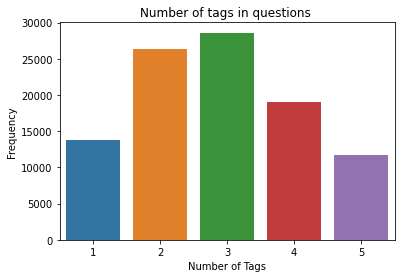

In [11]:
sns.countplot(df["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

*Implementing Bag Of Words Model for Visualization*

In [12]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df['Tags'])

In [13]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 99405
Number of unique tags : 18446


*Initial few tags*

In [14]:
tags = vectorizer.get_feature_names()
print("Few tags :", tags[:10])

Few tags : ['.a', '.bash-profile', '.class-file', '.each', '.emf', '.hgtags', '.htaccess', '.htpasswd', '.mov', '.net']


*Frequency count of each tag*

In [15]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [16]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 

In [17]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,2
1,.bash-profile,1
2,.class-file,1
3,.each,6
4,.emf,2


*Sorting Tags frequency count in desending order and visualing it.*

Text(0, 0.5, 'Frequency')

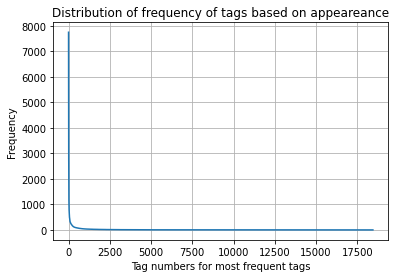

In [18]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

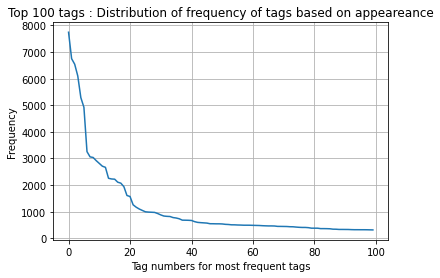

In [19]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

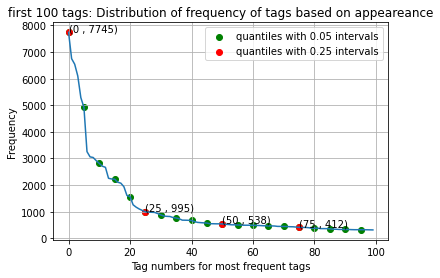

In [20]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.scatter(x=np.arange(0,100,5), y=tag_df_sorted['Counts'][0:100:5], c='g', label="quantiles with 0.05 intervals")
plt.scatter(x=np.arange(0,100,25), y=tag_df_sorted['Counts'][0:100:25], c='r', label = "quantiles with 0.25 intervals")
for x,y in zip(np.arange(0,100,25), tag_df_sorted['Counts'][0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.01, y+30))

plt.title('first 100 tags: Distribution of frequency of tags based on appeareance')
plt.grid()
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.legend()

In [21]:
print("{} tags are used more than 25 times".format(tag_df_sorted[tag_df_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_sorted[tag_df_sorted["Counts"]>50].shape[0]))

1481 tags are used more than 25 times
793 tags are used more than 50 times


*Wordcloud of tags based on frequency*

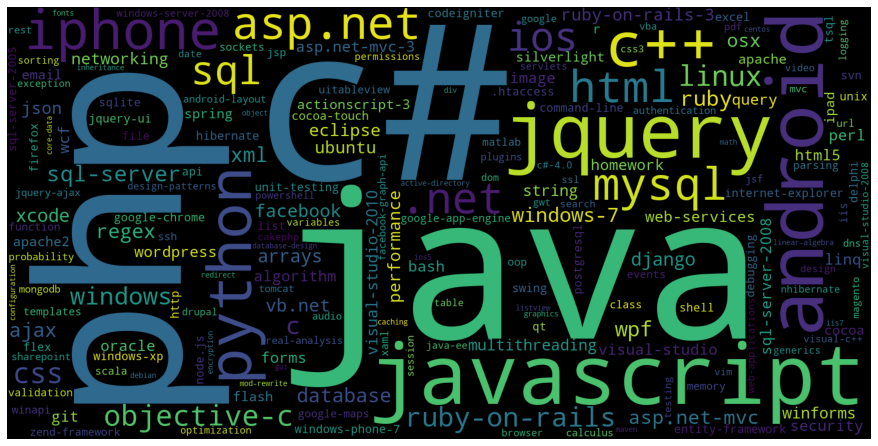

In [22]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

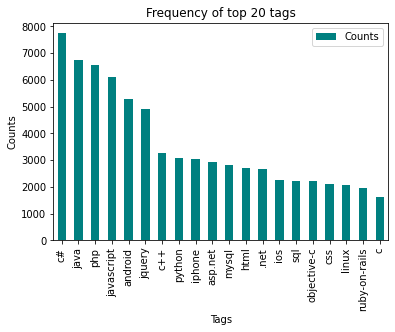

In [23]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar', color='teal')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [24]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

*Preprocessing the text data and merging Title and Body into one variable.*

In [26]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [27]:
qus_list=[]
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(body)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)

df["question"] = qus_list

In [28]:
preprocessed_df = df[["question","Tags"]]
print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (99405, 2)


*Implementing Bag of Words model for processing.*

In [29]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y_multilabel = vectorizer.fit_transform(preprocessed_df['Tags'])

*2D matrix of n most frequent tags.*

In [30]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel


*Counting questions with no tags out of n tags*

In [31]:
def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))
    

*Plotting and Visualizing the total tags to consider.*

In [32]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

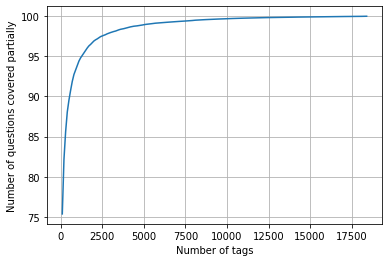

97.545 % of questions covered by 2500 tags
Number of questions that are not covered by 100 tags :  2440 out of  99405


In [33]:
plt.plot(np.arange(100,total_tags, 100),questions_covered)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions covered partially")
plt.grid()
plt.show()
print(questions_covered[24],"% of questions covered by 2500 tags")
print("Number of questions that are not covered by 100 tags : ", questions_covered_fn(2500),"out of ", total_qus)

*Considering 2500 most frequent tags.*

In [34]:
yx_multilabel = tags_to_consider(2500)
print("Number of tags in the subset :", y_multilabel.shape[1])
print("Number of tags considered :", yx_multilabel.shape[1],"(",(yx_multilabel.shape[1]/y_multilabel.shape[1])*100,"%)")

Number of tags in the subset : 18446
Number of tags considered : 2500 ( 13.553073837146265 %)


*Splitting the datset into Train and Test dataset*

In [35]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 79524
Number of data points in test data : 19881


In [36]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [37]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (79524, 89041) Y : (79524, 2500)
Test data shape X :  (19881, 89041) Y: (19881, 2500)


*Using OneVSRest Classifier with SGD Classifier and Log Loss*

In [39]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [ ]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 score :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))
#print("Precision recall report :\n",metrics.classification_report(y_test, y_pred))

*Performing Preprocessing by giving more weightage to the Title*

In [58]:
qus_list=[]
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(title)+" "+str(title)+" "+ body
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)

df["question_with_more_wt_title"] = qus_list


In [41]:
preprocessed_df = df[["question_with_more_wt_title","Tags"]]
print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (99405, 2)


*Splitting the dataset into Train and Test dataset*

In [42]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 79524
Number of data points in test data : 19881


In [43]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question_with_more_wt_title'])
X_test_multilabel = vectorizer.transform(X_test['question_with_more_wt_title'])

In [44]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (79524, 90610) Y : (79524, 2500)
Test data shape X :  (19881, 90610) Y: (19881, 2500)


*Using OneVSRest Classifier with Logistic Regression*

In [68]:
clf = OneVsRestClassifier(LogisticRegression(C=0.01, penalty='l1',solver='saga'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [70]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 score :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.04914239726371913
Macro f1 score : 0.0018265956493812028
Micro f1 score : 0.10338105271449108
Hamming loss : 0.0009161108596147075


*Using OneVSRest Classifier with SGD Classifier and Log Loss*

In [62]:
clf2 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf2.fit(X_train_multilabel, y_train)
y_pred = clf2.predict(X_test_multilabel)

In [63]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 score :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.09270157436748655
Macro f1 score : 0.05323603125625375
Micro f1 score : 0.31638024076380244
Hamming loss : 0.000828348674613953


*Using OneVSRest Classifier with SGD Classifier and Hinge Loss*

In [50]:
clf3 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
clf3.fit(X_train_multilabel, y_train)
y_pred = clf3.predict(X_test_multilabel)

In [54]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 score :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.1340475831195614
Macro f1 score : 0.23013490328840047
Micro f1 score : 0.42975055862100414
Hamming loss : 0.0007547910064886072


*Tabulating the various used models*

In [71]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["S.No", "Classification model", "Penalty", "F1 micro", "F1 macro", "Hamming Loss"]

x.add_row(["1.", "OneVsRest+Logistic Regression", "L1", 0.1034, 0.0018, 0.0009])
x.add_row(["2.", "OneVsRest+SGD(Loss=log)", "L2", 0.3163, 0.0532, 0.0008])
x.add_row(["3.", "OneVsRest+SGD(Loss=Hinge)", "L1",0.4297, 0.2301, 0.0007])

print(x)

+------+-------------------------------+---------+----------+----------+--------------+
| S.No |      Classification model     | Penalty | F1 micro | F1 macro | Hamming Loss |
+------+-------------------------------+---------+----------+----------+--------------+
|  1.  | OneVsRest+Logistic Regression |    L1   |  0.1034  |  0.0018  |    0.0009    |
|  2.  |    OneVsRest+SGD(Loss=log)    |    L2   |  0.3163  |  0.0532  |    0.0008    |
|  3.  |   OneVsRest+SGD(Loss=Hinge)   |    L1   |  0.4297  |  0.2301  |    0.0007    |
+------+-------------------------------+---------+----------+----------+--------------+
